<a href="https://colab.research.google.com/github/RNy7846/Aprendizado_GANS/blob/main/GAN_de_Gatinho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![](https://miro.medium.com/max/1800/1*TKr1dtcNgJCA8uYY1OhmSg.png)

# GANs for Cats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/TESTE DE GAN'
print(os.listdir(dir))

['cats', 'Geradas', 'GAN de Gatinho.ipynb']


In [ ]:
##printing first 20 image names
print(os.listdir(dir+'/cats')[:20])

['873.jpg', '9865.jpg', '8891.jpg', '9934.jpg', '9371.jpg', '9765.jpg', '9386.jpg', '9925.jpg', '894.jpg', '8937.jpg', '8948.jpg', '9422.jpg', '9178.jpg', '8715.jpg', '9519.jpg', '9071.jpg', '9129.jpg', '8997.jpg', '9906.jpg', '9708.jpg']


In [ ]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

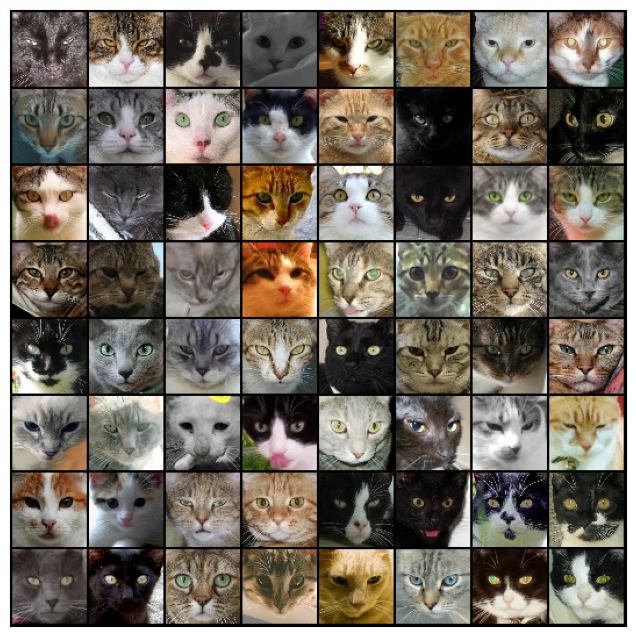

In [ ]:
show_batch(train_dl)

In [ ]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA Disponivel.Treinando na GPU")
        return torch.device('cuda')
    else:
        print("CUDA não Disponivel.Treinando na CPU")
        return torch.device('cpu')


In [ ]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
is_cuda_available()

CUDA Disponivel.Treinando na GPU


device(type='cuda')

In [ ]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA Disponivel.Treinando na GPU


In [ ]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    )

torch.Size([64, 3, 64, 64])


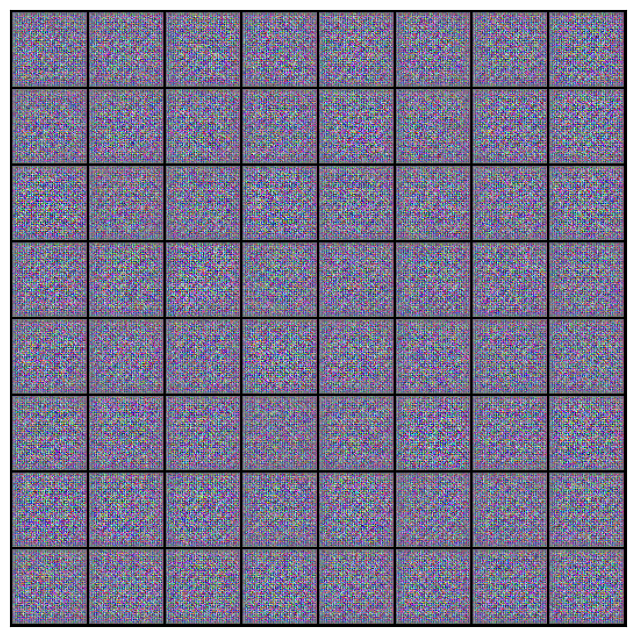

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()


In [ ]:
sample_dir = (dir+'/Geradas')
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Salvando', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Salvando generated-images-0000.png


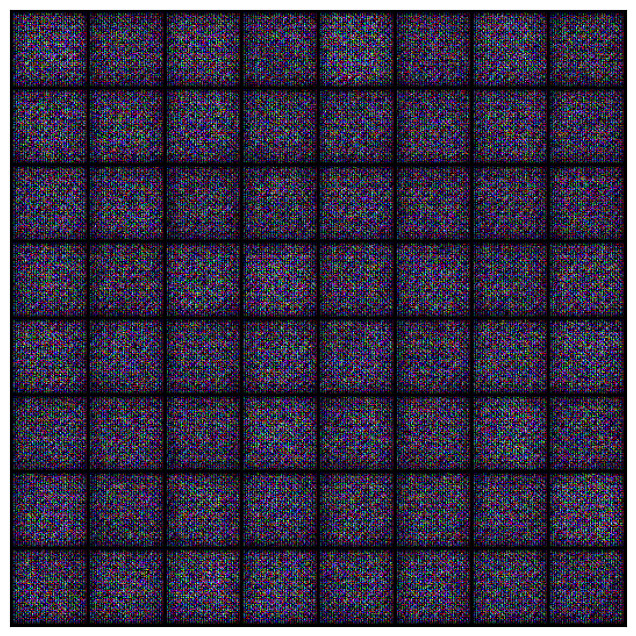

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoca [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0001
epochs = 400

In [ ]:
history=fit(epochs,lr)

  0%|          | 0/493 [00:00<?, ?it/s]

Epoca [1/400], loss_g: 7.9878, loss_d: 0.0181, real_score: 0.9980, fake_score: 0.0158
Salvando generated-images-0001.png


  0%|          | 0/493 [00:00<?, ?it/s]

Epoca [2/400], loss_g: 7.1663, loss_d: 0.2186, real_score: 0.8949, fake_score: 0.0016
Salvando generated-images-0002.png


  0%|          | 0/493 [00:00<?, ?it/s]

Epoca [3/400], loss_g: 6.7370, loss_d: 0.0659, real_score: 0.9815, fake_score: 0.0427
Salvando generated-images-0003.png


  0%|          | 0/493 [00:00<?, ?it/s]

Epoca [4/400], loss_g: 5.7743, loss_d: 0.0212, real_score: 0.9928, fake_score: 0.0134
Salvando generated-images-0004.png


  0%|          | 0/493 [00:00<?, ?it/s]

Epoca [5/400], loss_g: 7.1244, loss_d: 0.1062, real_score: 0.9779, fake_score: 0.0753
Salvando generated-images-0005.png


  0%|          | 0/493 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image

In [ ]:
Image('./Geradas/generated-images-0080.png')

In [ ]:

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Imagens Reais', 'Imagens Fakes'])
plt.title('Scores');

In [ ]:
save_samples(0, fixed_latent)